In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

In [2]:
#%matplotlib notebook

## Read Data

In [12]:
#load data, drop the name, episodes, and members
## Read data
data_path = './data'
anime = pd.read_csv(os.path.join(data_path,'anime_cleaned.csv')).drop(['name','episodes','rating','members'],axis=1)#keep genre
rating = pd.read_csv(os.path.join(data_path,'rating_cleaned.csv'))
#read dataset with names
animeWithName = pd.read_csv(os.path.join(data_path,'anime_cleaned.csv'))

## Creat dataset

In [7]:
animeData = np.array(anime).astype(int)

## PCA 
### Reduce to 3-dimension

In [8]:
pca = PCA(n_components = 3)
pca.fit(animeData[:,1:len(animeData)-4])
pca_samples = pca.transform(animeData[:,1:len(animeData)-4])
print(pca_samples)
tocluster = pd.DataFrame(pca_samples)
tocluster

[[ 0.3402713  -0.53746587 -0.43807083]
 [ 0.34325458  1.38324675  0.28163318]
 [-0.43502552  1.22761972  0.03506796]
 ...
 [ 0.8564951   0.43427184 -0.48663808]
 [ 0.38173381 -0.47766576 -0.82420475]
 [ 0.3499529  -0.48388959 -0.37547076]]


,0,1,2
0,0.340271,-0.537466,-0.438071
1,0.343255,1.383247,0.281633
2,-0.435026,1.227620,0.035068
3,-0.100976,0.481429,-0.621101
4,-0.435026,1.227620,0.035068
...,...,...,...
10251,0.247432,-0.698524,-1.089373
10252,0.898005,0.431365,-0.516348
10253,0.856495,0.434272,-0.486638
10254,0.381734,-0.477666,-0.824205


## K-means

In [9]:
clusterer = KMeans(n_clusters=6,random_state=10).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)

for i in centers:
 print(i)

plt.rcParams['figure.figsize'] = (9, 7)

[ 0.80214687  0.33826525 -0.10960858]
[-0.41594815 -0.44381561  0.2338692 ]
[-0.7377897   0.18731098 -0.23800034]
[0.24278213 0.01837014 0.83403495]
[ 0.3250874 -0.5254688 -0.2461322]
[ 0.00749454  0.96938538 -0.1557719 ]


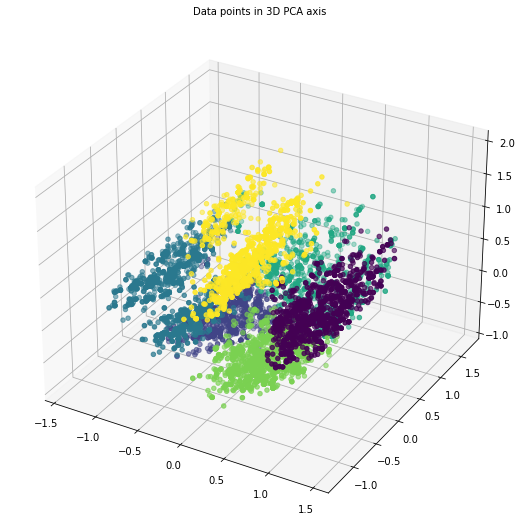

In [10]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(tocluster[0], tocluster[2], tocluster[1], c = c_preds)
plt.title('Data points in 3D PCA axis', fontsize=10)
plt.show()

 ## Regenerate Centers with Anime Names

In [13]:
#assign each anime with its cluster
animeWithName['cluster centers'] = c_preds
animeWithName['pca_x'] = tocluster[0]
animeWithName['pca_y'] = tocluster[1]
animeWithName['pca_z'] = tocluster[2]

In [14]:
#define function to view a cluster dedicatly
def clusterView(df):
    colNames = [column for column in df]
    #only read the genre of animes
    genreNames = colNames[5:len(colNames) - 8]#only count genre
    genreDict = {}
    nameDict = {}
    #create empty dict for cols
    for i in genreNames:
        genreDict [i] = 0
    for i in genreNames:
        genreScore = np.sum(df[i])
        genreDict [i] = genreScore
    #sort the map
    genreSort = sorted(genreDict.items(), key = lambda kv:(kv[1], kv[0]))
    print("liked genres and appeared time:")
    for i in reversed(genreSort):
        print(i)    
    
    return reversed(genreSort)       

In [41]:
def pickTopAnime(df):
    #get the center
    center = df['cluster centers']
    clusterCenter = centers[center - 1]
    #choose the nearest datapoint
    pcaPoints = df[['pca_x','pca_y','pca_z']]
    
    distances = [] 
    
    center = np.array(clusterCenter)
    pcas = np.array(pcaPoints)
   
    distances = np.sum(np.square(center-pcas),1) 
    listDistances = distances.tolist()
    
    topAnime = {}
    
    for i in range(len(listDistances)):
        topAnime[df.iloc[i,1]] = (listDistances[i])
      
     
    animeSort =  sorted(topAnime.items(), key = lambda kv:(kv[1], kv[0]))
    #print( animeSort)
    return animeSort
    

In [42]:
 def getMean(userid, rating, anime):
    user = rating.loc[rating['user_id']==userid]
    mean = np.mean(user['rating'])
    animeLike = np.array(user.loc[user['rating'] > mean]['anime_id'])
    x = 0.0
    y = 0.0
    z = 0.0
    count = 0
    for i in animeLike:
        try:
            temp = anime.loc[anime['anime_id'] == i]
        except:
            continue
        count += 1
        x += float(temp['pca_x'])
        y += float(temp['pca_y'])
        z += float(temp['pca_z'])
    return [x/count,y/count,z/count]

In [43]:
def recommand(mean, centers):
    shortest = 10000.0
    idx = 0
    for c in range(len(centers)):
        distance = np.sqrt(np.sum((centers[c] - mean)**2))
        if distance < shortest:
            shortest = distance
            idx = c
    return idx

 ## Recommendation system test out

In [44]:
#allocating clusters:
animeClusters = []
genreScores = []
topAnimes = []
for i in range(7):
    animeClusters.append(animeWithName.loc[animeWithName['cluster centers']==i])
usermean = getMean(11,rating,animeWithName)
print("the user mean are: ",usermean)
index = recommand(usermean,centers)
print("choosing clustering #",index)

the user mean are:  [0.06337023260571875, 0.2792280532211388, 0.17384568943738]
choosing clustering # 3


In [45]:
print(clusterView(animeClusters[index]))

liked genres and appeared time:
('genre_Adventure', 907.0)
('genre_Fantasy', 843.0)
('type_Movie', 785)
('genre_Comedy', 742.0)
('genre_Shounen', 470.0)
('genre_Action', 408.0)
('genre_Kids', 400.0)
('genre_Magic', 149.0)
('genre_Sci-Fi', 138.0)
('genre_Supernatural', 115.0)
('genre_SuperPower', 90.0)
('genre_Drama', 74.0)
('genre_Mystery', 69.0)
('genre_Historical', 64.0)
('genre_Romance', 47.0)
('genre_MartialArts', 47.0)
('genre_Police', 43.0)
('genre_Demons', 43.0)
('genre_Shoujo', 36.0)
('genre_Sports', 33.0)
('genre_Horror', 28.0)
('genre_Mecha', 27.0)
('genre_Game', 25.0)
('genre_Parody', 22.0)
('genre_Space', 18.0)
('genre_School', 18.0)
('genre_Samurai', 17.0)
('genre_SliceofLife', 16.0)
('genre_Seinen', 14.0)
('genre_Military', 14.0)
('genre_Music', 12.0)
('genre_Psychological', 9.0)
('genre_Dementia', 6.0)
('genre_Cars', 5.0)
('genre_Vampire', 4.0)
('genre_ShounenAi', 3.0)
('type_Music', 2)
('genre_Thriller', 1.0)
('genre_Josei', 1.0)
('genre_Yuri', 0.0)
('genre_Yaoi', 0.0)


In [46]:
rec_list = pickTopAnime(animeClusters[index])
print("top pick for the user is: ", rec_list[0][0])

top pick for the user is:  Tanoshii Muumin Ikka Bouken Nikki
